In [1]:
from __future__ import annotations

import abc
from typing import List, Tuple, Union

In [2]:
import platform

import cpuinfo
import psutil

with open("../ood-synthesis/system.tex", "w") as file:
    print("All tests were again performed on a ", end="", file=file)

    uname = platform.uname()
    print(f"{uname.system} ({uname.release})".replace("_", r"\_"), end="", file=file)
    print(" machine with an ", end="", file=file)
    print(
        f"{cpuinfo.get_cpu_info()['brand_raw']} ({uname.processor})".replace(
            "_", r"\_",
        ), end="", file=file,
    )

    print(" processor with ", end="", file=file)

    print(f"{psutil.cpu_count(logical=False)} physical and ", end="", file=file)
    print(f"{psutil.cpu_count(logical=True)} total CPU cores ", end="", file=file)

    svmem = psutil.virtual_memory()
    print(f"and {svmem.total/(1024*1024*1024):.2f}GiB of RAM.", file=file)

In [3]:
import auto_diff
import matplotlib as mpl
import numpy as np
import sklearn

from matplotlib import pyplot as plt

from sklearn.neighbors import KernelDensity
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import roc_auc_score

In [4]:
import colorcet

conf_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'confidence_cmap', colorcet.m_CET_L20(np.linspace(0, 1.0/1.2, 1000)),
)
diff_cmap = "cet_CET_L20"

In [5]:
import phepy

from phepy.detector import OutOfDistributionDetector, OutOfDistributionScorer
from phepy.plot import plot_all_toy_examples, ColorBar
from phepy.toys import ToyExample
from phepy.toys.line import LineToyExample
from phepy.toys.circle import CircleToyExample
from phepy.toys.haystack import HaystackToyExample

In [6]:
conf_cbar = ColorBar(
    title="confidence level $c$",
    low="0.1",
    high="0.9",
)
diff_cbar = ColorBar(
    title="change in confidence level $c$",
    low="$<$ ",
    high="$>$ ",
)

In [7]:
line = LineToyExample(np.random.default_rng(42), N=10_000)
circle = CircleToyExample(np.random.default_rng(42), N=10_000)
haystack = HaystackToyExample(np.random.default_rng(42), N=10_000)

In [8]:
def get_toy_for_data(X_train: np.ndarray) -> ToyExample:
    for toy in [line, circle, haystack]:
        if X_train.shape != toy.X_train.shape:
            continue

        if np.all(X_train == toy.X_train):
            return toy

    raise KeyError("unknown toy example")

In [9]:
scores = []

def collect_synthesiser_scores(scorer, toy, evaluation, ax):
    TP = np.sum(evaluation.confidence * evaluation.expected)
    FP = np.sum(evaluation.confidence * (1 - evaluation.expected))
    # TN = np.sum((1 - evaluation.confidence) * (1 - evaluation.expected))
    FN = np.sum((1 - evaluation.confidence) * evaluation.expected)

    precision = TP / (TP + FP)
    f1 = 2 * TP / (2 * TP + FP + FN)
    roc = roc_auc_score(evaluation.expected, evaluation.confidence)
    
    scores.append([
        type(scorer.synthesiser), type(toy),
        precision, f1, roc, evaluation.fit_time,
        evaluation.predict_time, evaluation.detector_size,
    ])
    
    # Also annotate the plots with a subsample of the synthetic OOD samples
    X_train_ood = scorer.X_train_ood
    N_skip = len(X_train_ood) // 200
    
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    
    if toy == line or toy == circle:
        ax.scatter(
            X_train_ood[::N_skip,0], X_train_ood[::N_skip,1],
            c='white', s=4, rasterized=True,
        )
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [10]:
class OutOfDistributionSynthesiser(abc.ABC):
    @abc.abstractmethod
    def synthesise(self, X_train_id: np.ndarray) -> np.ndarray:
        pass

In [11]:
class SupervisedMultilayerPerceptronDetector(OutOfDistributionDetector, OutOfDistributionScorer):
    def __init__(self, synthesiser: OutOfDistributionSynthesiser):
        self.__synthesiser = synthesiser
        
    @property
    def synthesiser(self) -> OutOfDistributionSynthesiser:
        return self.__synthesiser
    
    @property
    def detector(self) -> OutOfDistributionDetector:
        return self
    
    @staticmethod
    def low_score_is_low_confidence() -> bool:
        return True
    
    def fit(
        self, X_train: np.ndarray, Y_train: np.ndarray
    ) -> SupervisedMultilayerPerceptronDetector:
        X_train_id = X_train
        self.__X_train_ood = self.synthesiser.synthesise(X_train_id)
        
        self.__X_mlp = MLPClassifier(activation="relu", max_iter=1500, random_state=42).fit(
            np.concatenate([X_train_id, self.__X_train_ood]),
            np.concatenate([
                np.ones(shape=len(X_train_id)),
                np.zeros(shape=len(self.__X_train_ood)),
            ]),
        )
        
        return self
    
    @property
    def X_train_ood(self):
        return self.__X_train_ood
    
    def calibrate(
        self, X_valid: np.ndarray, Y_valid: np.ndarray
    ) -> SupervisedMultilayerPerceptronDetector:
        return self

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        return self.__X_mlp.predict_proba(X_test)[:,1]

In [12]:
class UniformSynthesiser(OutOfDistributionSynthesiser):
    def synthesise(self, X_train_id: np.ndarray) -> np.ndarray:
        return np.random.default_rng(24).uniform(
            np.amin(X_train_id, axis=0) - 1,
            np.amax(X_train_id, axis=0) + 1,
            size=X_train_id.shape,
        )

In [13]:
class FastGradientSignSynthesiser(OutOfDistributionSynthesiser):
    def step_size(self, shape: Tuple[int, ...]) -> Union[float, np.ndarray]:
        # constant step size
        return 1.0
    
    def synthesise(self, X_train_id: np.ndarray) -> np.ndarray:
        # synthesise ID samples
        kde = KernelDensity(bandwidth=0.05, kernel="gaussian").fit(X_train_id)
        X_synth_id = kde.sample(len(X_train_id), random_state=42)
        
        # we need access to the toy example here to calculate the error gradient
        toy = get_toy_for_data(X_train_id)
        
        # calculate the MSE gradient wrt to the synthetic ID samples
        with auto_diff.AutoDiff(X_synth_id) as X_synth_id_ad:
            X_pred_id_ad = toy.reconstruct(X_synth_id_ad)
            X_mse_id_ad = (X_pred_id_ad - X_synth_id_ad) ** 2

            X_mse_sum_id_ad = X_mse_id_ad[:,0]
            for i in range(1, X_mse_id_ad.shape[1]):
                X_mse_sum_id_ad += X_mse_id_ad[:,i]
            # X_mse_sum_id_ad now contains the result of np.sum(X_mse_id, axis=1)

            adv_grad = np.diagonal(X_mse_sum_id_ad.der).T
        
        # apply the FGSM method with the chosen step size
        X_synth_ood = X_synth_id + np.sign(adv_grad) * self.step_size(adv_grad.shape)
        
        return X_synth_ood

/workspace/msc-tcm/papers/phoebe/phepy/phepy/toys/circle.py:126: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(x1 / x2)
/workspace/msc-tcm/papers/phoebe/phepy/phepy/toys/circle.py:126: RuntimeWarning: invalid value encountered in divide
  a = np.arctan(x1 / x2)
/workspace/msc-tcm/papers/phoebe/phepy/phepy/toys/circle.py:126: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(x1 / x2)
/workspace/msc-tcm/papers/phoebe/phepy/phepy/toys/circle.py:126: RuntimeWarning: invalid value encountered in divide
  a = np.arctan(x1 / x2)


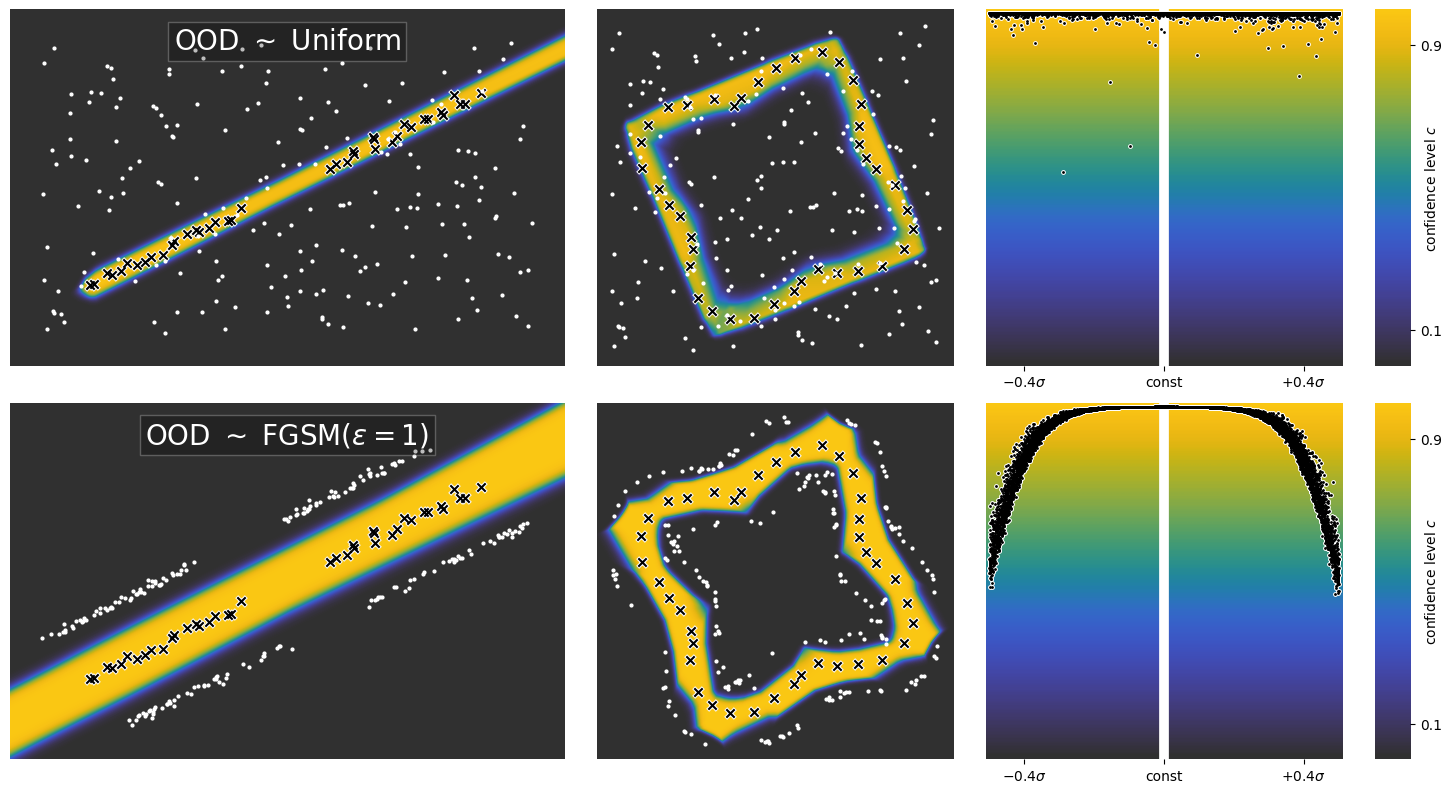

In [14]:
fig = plot_all_toy_examples(
    scorers = {
        r"OOD $\sim$ Uniform": SupervisedMultilayerPerceptronDetector(UniformSynthesiser()),
        r"OOD $\sim$ FGSM($\epsilon = 1$)": SupervisedMultilayerPerceptronDetector(
            FastGradientSignSynthesiser()
        ),
    },
    toys = [line, circle, haystack],
    cmap = conf_cmap,
    with_scorer = collect_synthesiser_scores,
)

plt.savefig(
    "../ood-synthesis/figures/ood-synthesis/ood-synthesis-u01-fgsm.pdf",
    dpi=100, transparent=True, bbox_inches='tight',
)

plt.show()

In [15]:
class FastGradientSignUniformStepSynthesiser(FastGradientSignSynthesiser):
    def step_size(self, shape: Tuple[int, ...]) -> Union[float, np.ndarray]:
        # uniform(0.0, 1.0) step size
        return np.random.default_rng(seed=242).random(size=tuple(list(shape[:-1])+[1]))

In [16]:
class FastGradientSignTPokeSynthesiser(OutOfDistributionSynthesiser):
    def synthesise(self, X_train_id: np.ndarray) -> np.ndarray:
        # synthesise ID samples
        kde = KernelDensity(bandwidth=0.05, kernel="gaussian").fit(X_train_id)
        X_synth_id = kde.sample(len(X_train_id), random_state=42)
        
        # we need access to the toy example here to calculate the error gradient
        toy = get_toy_for_data(X_train_id)
        
        # calculate the MSE gradient wrt to the synthetic ID samples
        with auto_diff.AutoDiff(X_synth_id) as X_synth_id_ad:
            X_pred_id_ad = toy.reconstruct(X_synth_id_ad)
            X_mse_id_ad = (X_pred_id_ad - X_synth_id_ad) ** 2

            X_mse_sum_id_ad = X_mse_id_ad[:,0]
            for i in range(1, X_mse_id_ad.shape[1]):
                X_mse_sum_id_ad += X_mse_id_ad[:,i]
            # X_mse_sum_id_ad now contains the result of np.sum(X_mse_id, axis=1)

            adv_grad = np.diagonal(X_mse_sum_id_ad.der).T
            
        t = 1.0
        mult = 2.0
        last = None
        
        patience = 10
        mean_id_conf = 0.0
        
        # search for a good t value for t-poking, max 10 iterations
        while patience > 0 or mean_id_conf < 0.9:
            # apply the FGSM method with the chosen step size
            X_synth_ood = X_synth_id + np.sign(adv_grad) * t
            
            # train a test classifier to see the effect of t
            X_mlp = MLPClassifier(activation="relu", max_iter=1500, random_state=42).fit(
                np.concatenate([X_train_id, X_synth_ood]),
                np.concatenate([
                    np.ones(shape=len(X_train_id)),
                    np.zeros(shape=len(X_synth_ood)),
                ]),
            )
            
            # measure the mean confidence value for ID data
            mean_id_conf = np.mean(X_mlp.predict_proba(X_train_id)[:,1])
            
            print(t, mean_id_conf)
            
            # adjust t iteratively to aim for 0.95 <= mean_id_conf < 0.955
            if mean_id_conf < 0.95:
                if last == "down":
                    mult = 1.0 + (mult-1.0) * 0.5
                t *= mult
                last = "up"
            elif mean_id_conf >= 0.955:
                if last == "up":
                    mult = 1.0 + (mult-1.0) * 0.5
                t /= mult
                last = "down"
            else:
                break
            
            patience -= 1
        
        # return the synthetic OOD samples with the identified t value
        return X_synth_ood

/workspace/msc-tcm/papers/phoebe/phepy/phepy/toys/circle.py:126: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(x1 / x2)
/workspace/msc-tcm/papers/phoebe/phepy/phepy/toys/circle.py:126: RuntimeWarning: invalid value encountered in divide
  a = np.arctan(x1 / x2)


1.0 0.9996198585271506
0.5 0.9990135271979849
0.25 0.9935872498370804
0.125 0.8851728349879501
0.1875 0.9706353420047271
0.15 0.9327963539613539
0.16874999999999998 0.9515401202231669
1.0 0.9953553601806214
0.5 0.967678844544099
0.25 0.49901956615364906
0.375 0.4991666172928114
0.5625 0.9755878422068885
0.45 0.9561705840252096
0.36 0.4990772398759679
0.40499999999999997 0.9240585876650371
0.45562499999999995 0.9634103258676471
0.42882352941176466 0.9436178159185789


/workspace/msc-tcm/papers/phoebe/phepy/phepy/toys/circle.py:126: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(x1 / x2)
/workspace/msc-tcm/papers/phoebe/phepy/phepy/toys/circle.py:126: RuntimeWarning: invalid value encountered in divide
  a = np.arctan(x1 / x2)


1.0 0.9996475460803669
0.5 0.9995764651368112
0.25 0.999476513834844
0.125 0.9991929900085723
0.0625 0.9989152221087745
0.03125 0.9978738956905873
0.015625 0.4925559122915812
0.0234375 0.9971324187704078
0.01875 0.9968197994174723
0.015 0.9964127284607672


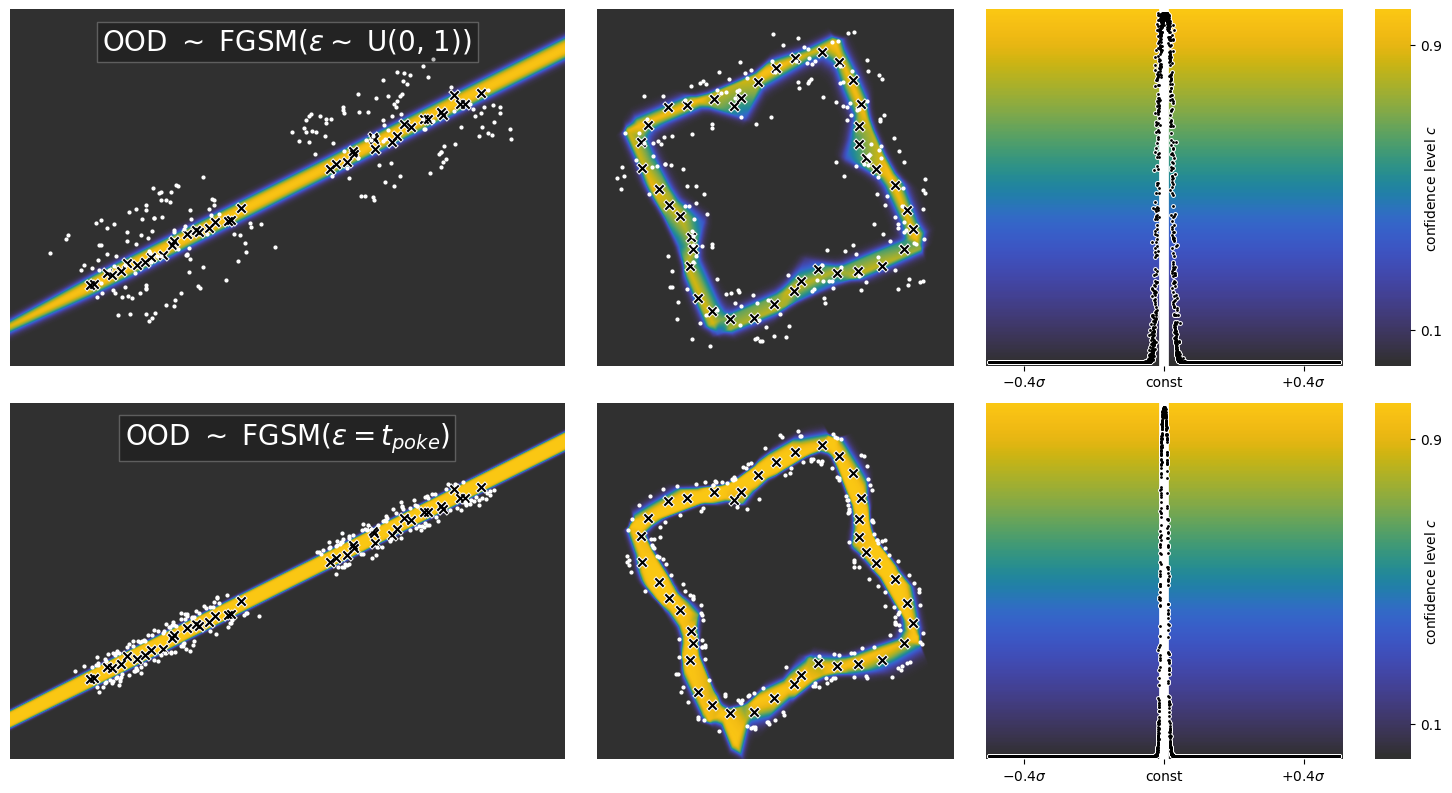

In [17]:
fig = plot_all_toy_examples(
    scorers = {
        r"OOD $\sim$ FGSM($\epsilon \sim$ U(0, 1))": SupervisedMultilayerPerceptronDetector(
            FastGradientSignUniformStepSynthesiser()
        ),
        r"OOD $\sim$ FGSM($\epsilon = t_{poke}$)": SupervisedMultilayerPerceptronDetector(
            FastGradientSignTPokeSynthesiser()
        ),
    },
    toys = [line, circle, haystack],
    cmap = conf_cmap,
    with_scorer = collect_synthesiser_scores,
)

plt.savefig(
    "../ood-synthesis/figures/ood-synthesis/ood-synthesis-fgsm-eps-u01-tpoke.pdf",
    dpi=100, transparent=True, bbox_inches='tight',
)

plt.show()

In [18]:
class OODWeightedSynthesiser(OutOfDistributionSynthesiser):
    def __init__(self, synthesiser: OutOfDistributionSynthesiser):
        self.__synthesiser = synthesiser
    
    def synthesise(self, X_train_id: np.ndarray) -> np.ndarray:
        X_synth_ood = self.__synthesiser.synthesise(X_train_id)
        
        # we need access to the toy example here to calculate the error
        toy = get_toy_for_data(X_train_id)
        
        X_train_id_error = toy.reconstruct(X_train_id) - X_train_id
        X_synth_ood_error = toy.reconstruct(X_synth_ood) - X_synth_ood
        
        kde_id_error = KernelDensity(bandwidth=0.1, kernel="linear").fit(X_train_id_error)
        kde_ood_error = KernelDensity(bandwidth=0.1, kernel="linear").fit(X_synth_ood_error)
        
        ood_pdf = np.exp(kde_ood_error.score_samples(X_synth_ood_error))
        ood_as_id_pdf = np.exp(kde_id_error.score_samples(X_synth_ood_error))
        
        imax_ood_as_id = np.argmax(ood_as_id_pdf)
        fact_ood_as_id = ood_pdf[imax_ood_as_id] / ood_as_id_pdf[imax_ood_as_id]
        
        sample_weight = 1.0 - ((ood_as_id_pdf * fact_ood_as_id / np.amax(ood_pdf)) / np.maximum(
            ood_as_id_pdf * fact_ood_as_id / np.amax(ood_pdf),
            ood_pdf / np.amax(ood_pdf)
        ))
        include_sample = np.random.default_rng(424).random(size=len(sample_weight)) < sample_weight
        
        self.__X_synth_ood = X_synth_ood
        self.__sample_weight = sample_weight
        
        return X_synth_ood[include_sample]
    
    def get_synthetic_weights(self) -> Tuple[np.ndarray, np.ndarray]:
        return (self.__X_synth_ood, self.__sample_weight)

In [19]:
class OODWeightedUniformSynthesiser(OODWeightedSynthesiser):
    def __init__(self):
        super().__init__(UniformSynthesiser())

In [20]:
class OODWeightedFastGradientSignUniformStepSynthesiser(OODWeightedSynthesiser):
    def __init__(self):
        super().__init__(FastGradientSignUniformStepSynthesiser())

In [21]:
class ScorerDifference(OutOfDistributionDetector, OutOfDistributionScorer):
    def __init__(self, baseline: OutOfDistributionScorer, comparison: OutOfDistributionScorer):
        self.__baseline = baseline
        self.__comparison = comparison
        
    @property
    def baseline(self) -> OutOfDistributionScorer:
        return self.__baseline
    
    @property
    def comparison(self) -> OutOfDistributionScorer:
        return self.__comparison
    
    @property
    def detector(self) -> OutOfDistributionDetector:
        return self
    
    @staticmethod
    def low_score_is_low_confidence() -> bool:
        return True
    
    def fit(
        self, X_train: np.ndarray, Y_train: np.ndarray
    ) -> ScorerDifference:
        self.__baseline.detector.fit(X_train, Y_train)
        self.__comparison.detector.fit(X_train, Y_train)
        
        return self
    
    def calibrate(
        self, X_valid: np.ndarray, Y_valid: np.ndarray
    ) -> ScorerDifference:
        self.__baseline.calibrate(X_valid, Y_valid)
        self.__comparison.calibrate(X_valid, Y_valid)
        
        return self

    def predict(self, X_test: np.ndarray) -> np.ndarray:
        S_baseline = self.__baseline.predict(X_test)
        S_comparison = self.__comparison.predict(X_test)
        
        vlim = np.amax(np.abs(S_comparison - S_baseline))
        
        return ((S_comparison - S_baseline) + vlim) / (vlim * 2.0)

In [22]:
def annotate_synthesiser_difference(scorer, toy, evaluation, ax):
    X_synth_ood, W_synth_ood = scorer.comparison.synthesiser.get_synthetic_weights()
    
    N_skip = len(X_synth_ood) // 200
    
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    
    if toy == line or toy == circle:
        ax.scatter(
            X_synth_ood[::N_skip,0], X_synth_ood[::N_skip,1],
            c='white', s=4, alpha=1.0-W_synth_ood, rasterized=True,
        )
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

/workspace/msc-tcm/papers/phoebe/phepy/phepy/toys/circle.py:126: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(x1 / x2)
/workspace/msc-tcm/papers/phoebe/phepy/phepy/toys/circle.py:126: RuntimeWarning: invalid value encountered in divide
  a = np.arctan(x1 / x2)
/workspace/msc-tcm/papers/phoebe/phepy/phepy/toys/circle.py:126: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(x1 / x2)
/workspace/msc-tcm/papers/phoebe/phepy/phepy/toys/circle.py:126: RuntimeWarning: invalid value encountered in divide
  a = np.arctan(x1 / x2)
/workspace/msc-tcm/papers/phoebe/phepy/phepy/toys/circle.py:126: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(x1 / x2)
/workspace/msc-tcm/papers/phoebe/phepy/phepy/toys/circle.py:126: RuntimeWarning: invalid value encountered in divide
  a = np.arctan(x1 / x2)
/workspace/msc-tcm/papers/phoebe/phepy/phepy/toys/circle.py:126: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(x1 / x2)
/w

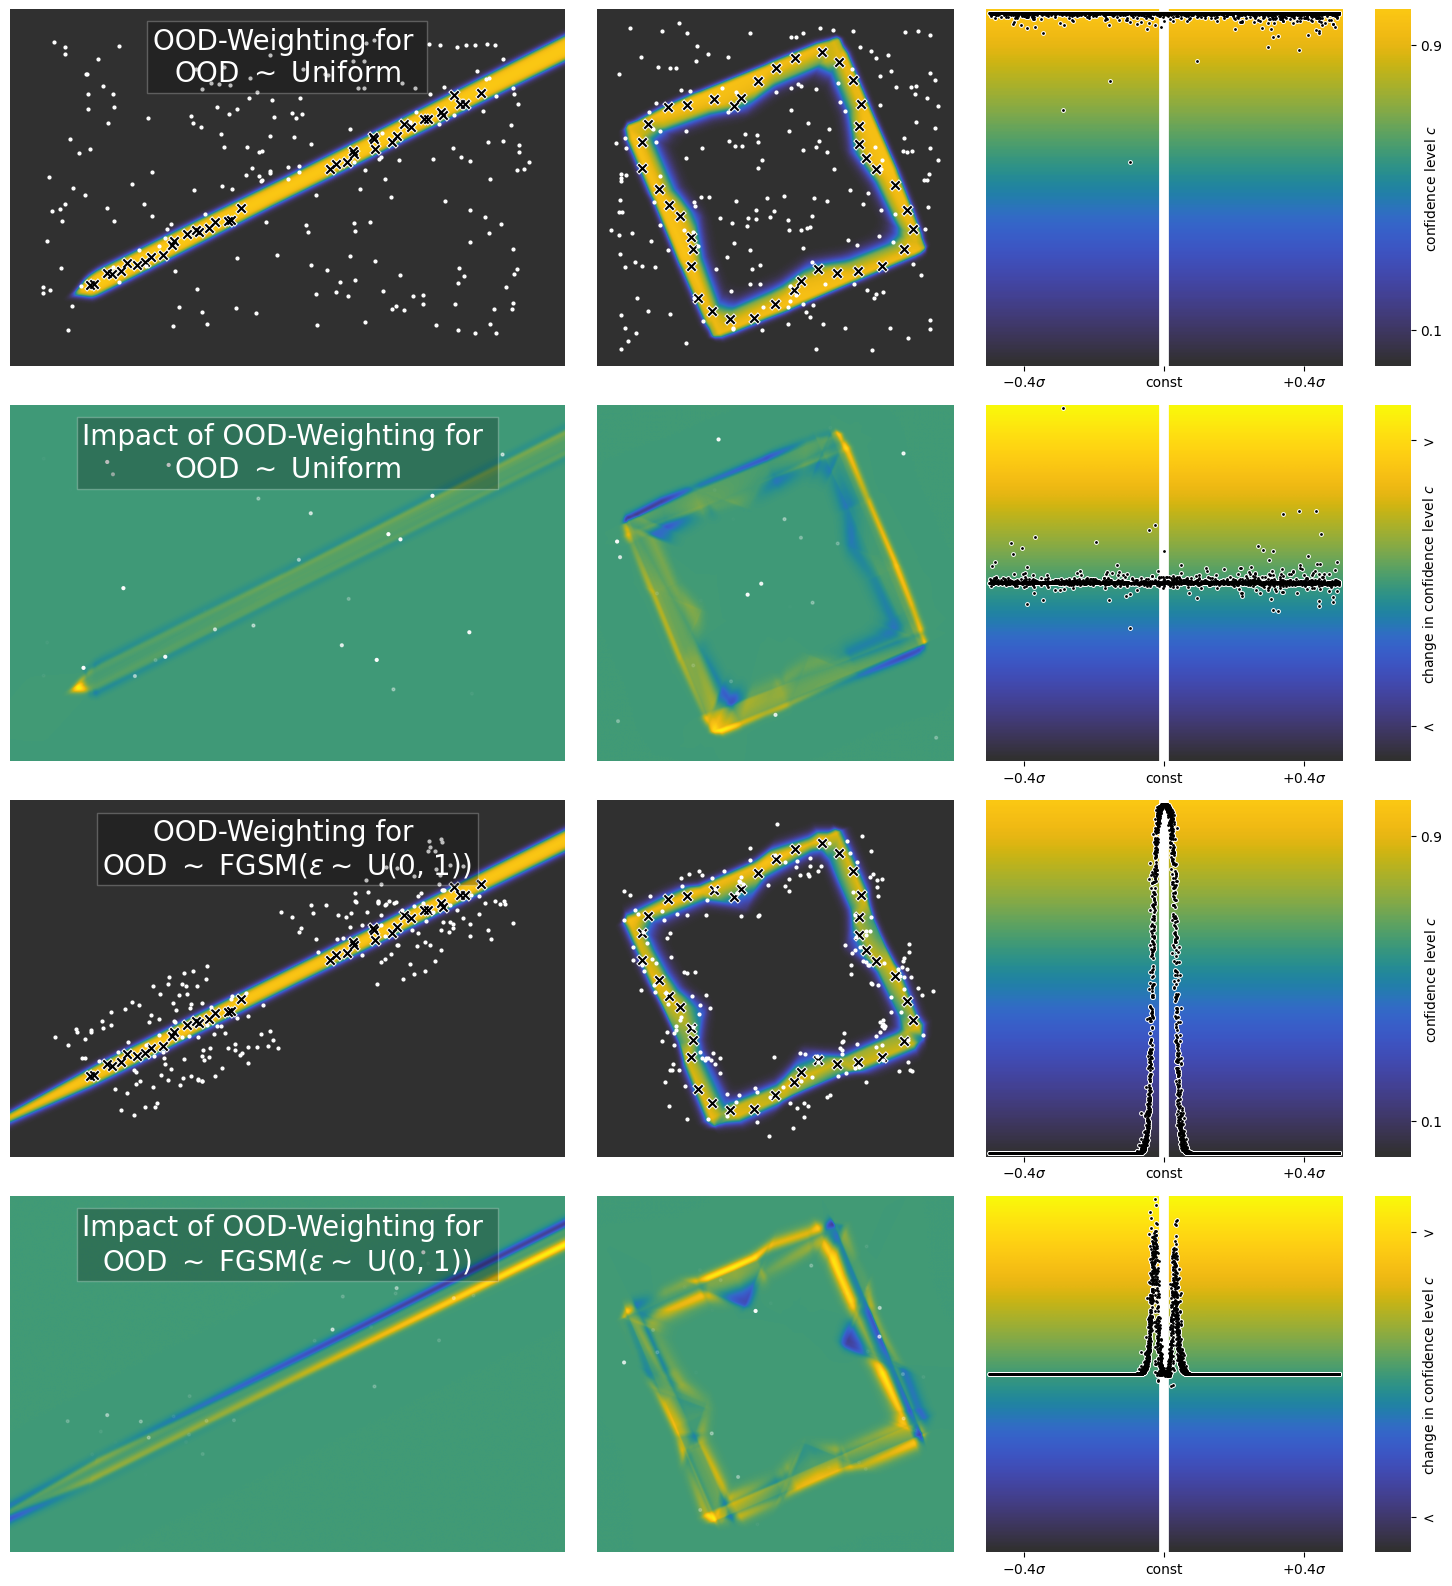

In [23]:
fig = plot_all_toy_examples(
    scorers = {
        "OOD-Weighting for \n" + r"OOD $\sim$ Uniform": SupervisedMultilayerPerceptronDetector(
            OODWeightedUniformSynthesiser(),
        ),
        "Impact of OOD-Weighting for \n" + r"OOD $\sim$ Uniform": ScorerDifference(
            baseline=SupervisedMultilayerPerceptronDetector(
                UniformSynthesiser(),
            ),
            comparison=SupervisedMultilayerPerceptronDetector(
                OODWeightedUniformSynthesiser(),
            ),
        ),
        "OOD-Weighting for \n" + r"OOD $\sim$ FGSM($\epsilon \sim$ U(0, 1))": (
            SupervisedMultilayerPerceptronDetector(
                OODWeightedFastGradientSignUniformStepSynthesiser(),
            )
        ),
        "Impact of OOD-Weighting for \n" + r"OOD $\sim$ FGSM($\epsilon \sim$ U(0, 1))": ScorerDifference(
            baseline=SupervisedMultilayerPerceptronDetector(
                FastGradientSignUniformStepSynthesiser(),
            ),
            comparison=SupervisedMultilayerPerceptronDetector(
                OODWeightedFastGradientSignUniformStepSynthesiser(),
            ),
        ),
    },
    toys = [line, circle, haystack],
    cmap = [conf_cmap, diff_cmap, conf_cmap, diff_cmap],
    with_cbar = [conf_cbar, diff_cbar, conf_cbar, diff_cbar],
    with_scorer = [
        collect_synthesiser_scores,
        annotate_synthesiser_difference,
        collect_synthesiser_scores,
        annotate_synthesiser_difference,
    ],
    with_scatter = [True, False, True, False],
)

plt.savefig(
    "../ood-synthesis/figures/ood-synthesis/ood-synthesis-weighted.pdf",
    dpi=100, transparent=True, bbox_inches='tight',
)

plt.show()

In [24]:
synthesiser_abbreviations = {
    UniformSynthesiser: r"\Fref{fig:u01-fgsm-ood-synthesis}{a} Uniform",
    FastGradientSignSynthesiser: r"\Fref{fig:u01-fgsm-ood-synthesis}{b} FGSM(1.0)",
    FastGradientSignUniformStepSynthesiser: r"\Fref{fig:fgsm-eps-u01-tpoke-ood-synthesis}{a} FGSM(U(0,1))",
    FastGradientSignTPokeSynthesiser: r"\Fref{fig:fgsm-eps-u01-tpoke-ood-synthesis}{b} FGSM($t_{poke}$)",
    OODWeightedUniformSynthesiser: r"\Fref{fig:weighted-ood-synthesis}{a} w(Uniform)",
    OODWeightedFastGradientSignUniformStepSynthesiser: r"\Fref{fig:weighted-ood-synthesis}{c} w(FGSM(U))",
}

score_formatters = [
    lambda precision: str(np.round(precision, 3)),
    lambda f1_score: str(np.round(f1_score, 3)),
    lambda roc_auc: str(np.round(roc_auc, 3)),
    lambda fitting_time: str(
        np.round(fitting_time, 2)
        if fitting_time < 10.0 else
        np.round(fitting_time, 1)
        if fitting_time < 100.0 else
        int(np.round(fitting_time, 0))
        if fitting_time < 1000.0 else
        f"{int(np.round(fitting_time/1000, 0))}e3"
    ),
    lambda scoring_time: str(
        np.round(scoring_time, 2)
        if scoring_time < 10.0 else
        np.round(scoring_time, 1)
        if scoring_time < 100.0 else
        int(np.round(scoring_time, 0))
        if scoring_time < 1000.0 else
        f"{int(np.round(scoring_time/1000, 0))}e3"
    ),
    lambda memory: str(
        np.round(memory / 1024, 2)
        if memory < 10024 else
        np.round(memory / 1024, 1)
        if memory < 100024 else
        int(np.round(memory / 1024, 0))
        if memory < 1000024 else
        f"{int(np.round(memory / (1024*1024), 0))}e3"
    ),
]

with open("../ood-synthesis/tables/ood-synthesis.tex", "w") as table:
    print(r"\begin{tabular}{@{}ccccccc@{}}", file=table)
    print(r"    \toprule", file=table)
    print("    " + " & ".join([
        "OOD Synthesiser", "Precision", "F$_1$ Score", "ROC-AUC",
        "Fitting Time [s]", "Scoring Time [s]", "Memory [kiB]",
    ]) + r"\\", file=table)
    print("    " + " & ".join(
        ["Toy Example"] + [r"L / C / H"] * 6
    ) + r"\\ \midrule", file=table)
    
    for i in range(0, len(scores), 3):
        synthesiser_l, toy_l, *scores_l = scores[i+0]
        synthesiser_c, toy_c, *scores_c = scores[i+1]
        synthesiser_h, toy_h, *scores_h = scores[i+2]
        
        assert synthesiser_l == synthesiser_c == synthesiser_h
        assert toy_l == LineToyExample
        assert toy_c == CircleToyExample
        assert toy_h == HaystackToyExample
        
        print("    ", end="", file=table)
        print(synthesiser_abbreviations[synthesiser_l], end="", file=table)
        
        for fmt, s_l, s_c, s_h in zip(score_formatters, scores_l, scores_c, scores_h):
            print(f" & {fmt(s_l)} / {fmt(s_c)} / {fmt(s_h)}", end="", file=table)
        
        print(r" \\", file=table)
    
    print(r"    \bottomrule", file=table)
    print(r"\end{tabular}", file=table)